<a href="https://colab.research.google.com/github/victoriaazabel/SEdigitalorganizations/blob/main/VictoriaZabel_LearningPortfolio_7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Collaborative Filtering - Learning Portfolio 7

This learning portfolio covers a movie recommendation topic and accordingly builds a recommmendation model. Concepts such as collaborative filtering, embedding, and dot products are explored here.

In [ ]:
from fastai.collab import *
from fastai.tabular.all import *
set_seed(42)

In [ ]:
# downloading the datasetusing a fastai function

path = untar_data(URLs.ML_100k)

In [ ]:
# the main file has four columns, user, movie, ratingn, and timestamp. 

ratings = pd.read_csv(path/'u.data', delimiter='\t', header=None,
                      names=['user','movie','rating','timestamp'])
ratings.head(6)

,user,movie,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596
5,298,474,4,884182806


In [ ]:
# taking popular movies.  the three categories for the numbers below are: sci fi, action, and old movies.
# the 0.98 means the movie scores high (almost 1) on sci fi and action, and newer with a score of -0.9, basically -1
last_skywalker = np.array([0.98,0.9,-0.9])

In [ ]:
# random user rating
user1 = np.array([0.9,0.8,-0.6])

and we can now calculate the match between this combination:

In [ ]:
# finding the match between this combination using a dot product
(user1*last_skywalker).sum()

2.1420000000000003

In [ ]:
casablanca = np.array([-0.99,-0.3,0.8])

In [ ]:
# matching user 1 with casablanca
(user1*casablanca).sum()

-1.611

gradient descent
1. randomly initializing parameters as latent factors for each user and movie
2. calculate predictions (dot product of each movie w each user)
  - if the first latent factor of a user for action movies is high and the movie is an action film (vice versa), it will have a high product. 
3. calculate loss with the mean squared error. By minimizing the loss we can optimize the paramters / latent factors.

In [ ]:
# viewing titles rather than movie IDs

movies = pd.read_csv(path/'u.item',  delimiter='|', encoding='latin-1',
                     usecols=(0,1), names=('movie','title'), header=None)
movies.head()

,movie,title
0,1,Toy Story (1995)
1,2,GoldenEye (1995)
2,3,Four Rooms (1995)
3,4,Get Shorty (1995)
4,5,Copycat (1995)


In [ ]:
# mearge with ratings to see ratings by title
ratings = ratings.merge(movies)
ratings.head(6)

,user,movie,rating,timestamp,title
0,196,242,3,881250949,Kolya (1996)
1,63,242,3,875747190,Kolya (1996)
2,226,242,5,883888671,Kolya (1996)
3,154,242,3,879138235,Kolya (1996)
4,306,242,5,876503793,Kolya (1996)
5,296,242,4,884196057,Kolya (1996)


In [ ]:
# create dataloadrs object
dls = CollabDataLoaders.from_df(ratings, item_name='title', bs=64)
dls.show_batch()

,user,title,rating
0,542,My Left Foot (1989),4
1,422,Event Horizon (1997),3
2,311,"African Queen, The (1951)",4
3,595,Face/Off (1997),4
4,617,Evil Dead II (1987),1
5,158,Jurassic Park (1993),5
6,836,Chasing Amy (1997),3
7,474,Emma (1996),3
8,466,Jackie Chan's First Strike (1996),3
9,554,Scream (1996),3


In [ ]:
# create matrices to represent the movie and user latent factor

n_users  = len(dls.classes['user'])
n_movies = len(dls.classes['title'])
n_factors = 5

user_factors = torch.randn(n_users, n_factors)
movie_factors = torch.randn(n_movies, n_factors)

In [ ]:
#one hot encode the indices so that we can look up the index of the movie in the movie latent factor matrix 
#so that we can use that for calculating the movie user combo

one_hot_3 = one_hot(3, n_users).float()

In [ ]:
user_factors.t() @ one_hot_3

tensor([-0.4586, -0.9915, -0.4052, -0.3621, -0.5908])

In [ ]:
user_factors[3]

tensor([-0.4586, -0.9915, -0.4052, -0.3621, -0.5908])

- doing this for a few indices at once to have a matrix is tedious, sooooo
- we use embedding, which multiplies one hot matrices by an embedding matrix
- make the model learn the characterization of uesrs and movies by analyzing existing relations between the two
- helps determine important features
- random vector of length n to each user and movie to make them learnable

In [ ]:
# collaborative filtering
# using classes before writing the model
# init is a method that initializes a state upon creation
# self = first parameter of any method in a class to get attributes

class Example:
    def __init__(self, a): self.a = a
    def say(self,x): return f'Hello {self.a}, {x}.'

In [ ]:
ex = Example('Sylvain')
ex.say('nice to meet you')

'Hello Sylvain, nice to meet you.'

In [ ]:
bex = Example('Victoria')
bex.say('you should really get more sleep')

'Hello Victoria, you should really get more sleep.'

In [ ]:
# a class to calculate the dot product
# batch size x 2 tensor shape, column contains user id and the second one movie id
# ptyhon calls forward when a method in class is called

class DotProduct(Module):
    def __init__(self, n_users, n_movies, n_factors):
        self.user_factors = Embedding(n_users, n_factors)
        self.movie_factors = Embedding(n_movies, n_factors)
        
    def forward(self, x):
        users = self.user_factors(x[:,0])
        movies = self.movie_factors(x[:,1])
        return (users * movies).sum(dim=1)

In [ ]:
x,y = dls.one_batch()
x.shape

torch.Size([64, 2])

Now that we have defined our architecture, and created our parameter matrices, we need to create a `Learner` to optimize our model. In the past we have used special functions, such as `cnn_learner`, which set up everything for us for a particular application. Since we are doing things from scratch here, we will use the plain `Learner` class:

In [ ]:
# create a learner to optimize the model using the learner class
# next: fit the model

model = DotProduct(n_users, n_movies, 50)
learn = Learner(dls, model, loss_func=MSELossFlat())

We are now ready to fit our model:

In [ ]:
learn.fit_one_cycle(5, 5e-3)

epoch,train_loss,valid_loss,time
0,1.344786,1.279100,00:07
1,1.093331,1.109981,00:07
2,0.958258,0.990199,00:07
3,0.814234,0.894916,00:12
4,0.780714,0.882022,00:08


In [ ]:
# using the sigmoid range 

class DotProduct(Module):
    def __init__(self, n_users, n_movies, n_factors, y_range=(0,5.5)):
        self.user_factors = Embedding(n_users, n_factors)
        self.movie_factors = Embedding(n_movies, n_factors)
        self.y_range = y_range
        
    def forward(self, x):
        users = self.user_factors(x[:,0])
        movies = self.movie_factors(x[:,1])
        return sigmoid_range((users * movies).sum(dim=1), *self.y_range)

In [ ]:
model = DotProduct(n_users, n_movies, 50)
learn = Learner(dls, model, loss_func=MSELossFlat())
learn.fit_one_cycle(5, 5e-3)

epoch,train_loss,valid_loss,time
0,0.972302,0.991141,00:07
1,0.870617,0.915232,00:08
2,0.677327,0.875926,00:07
3,0.483030,0.880021,00:07
4,0.374193,0.884209,00:09


In [ ]:
# need biases and not just weights to handle missing info

class DotProductBias(Module):
    def __init__(self, n_users, n_movies, n_factors, y_range=(0,5.5)):
        self.user_factors = Embedding(n_users, n_factors)
        self.user_bias = Embedding(n_users, 1)
        self.movie_factors = Embedding(n_movies, n_factors)
        self.movie_bias = Embedding(n_movies, 1)
        self.y_range = y_range
        
    def forward(self, x):
        users = self.user_factors(x[:,0])
        movies = self.movie_factors(x[:,1])
        res = (users * movies).sum(dim=1, keepdim=True)
        res += self.user_bias(x[:,0]) + self.movie_bias(x[:,1])
        return sigmoid_range(res, *self.y_range)

In [ ]:
model = DotProductBias(n_users, n_movies, 50)
learn = Learner(dls, model, loss_func=MSELossFlat())
learn.fit_one_cycle(5, 5e-3)

epoch,train_loss,valid_loss,time
0,0.935379,0.950517,00:07
1,0.841818,0.867305,00:07
2,0.595711,0.868791,00:07
3,0.415252,0.893113,00:07
4,0.291982,0.900676,00:07


- the model is worse?? weird
- maybe because of the validation loss?
- idk why

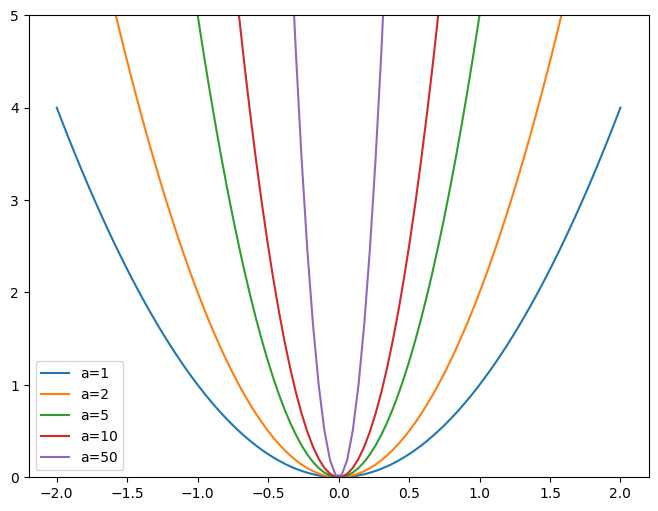

In [ ]:
# weight decaying so adding to loss function of the weights squared to make the weights as small as possible
# to prevent overfitting

x = np.linspace(-2,2,100)
a_s = [1,2,5,10,50] 
ys = [a * x**2 for a in a_s]
_,ax = plt.subplots(figsize=(8,6))
for a,y in zip(a_s,ys): ax.plot(x,y, label=f'a={a}')
ax.set_ylim([0,5])
ax.legend();

In [ ]:
# limiting weights hinders trainng but gets to a more generalized state

model = DotProductBias(n_users, n_movies, 50)
learn = Learner(dls, model, loss_func=MSELossFlat())
learn.fit_one_cycle(5, 5e-3, wd=0.1)

epoch,train_loss,valid_loss,time
0,0.921140,0.950414,00:10
1,0.882541,0.878911,00:09
2,0.765740,0.829301,00:10
3,0.597118,0.819820,00:08
4,0.497317,0.820298,00:08


In [ ]:
# randomly initi weigth matrices for each embeddings

class T(Module):
    def __init__(self): self.a = torch.ones(3)

L(T().parameters())

(#0) []

In [ ]:
class T(Module):
    def __init__(self): self.a = nn.Parameter(torch.ones(3))

L(T().parameters())

(#1) [Parameter containing:
tensor([1., 1., 1.], requires_grad=True)]

In [ ]:
class T(Module):
    def __init__(self): self.a = nn.Linear(1, 3, bias=False)

t = T()
L(t.parameters())

(#1) [Parameter containing:
tensor([[0.8652],
        [0.3820],
        [0.4437]], requires_grad=True)]

In [ ]:
type(t.a.weight)

torch.nn.parameter.Parameter

In [ ]:
# creating a tensor as parameter 

def create_params(size):
    return nn.Parameter(torch.zeros(*size).normal_(0, 0.01))

In [ ]:
# using all of this to recreate the bias without embedding

class DotProductBias(Module):
    def __init__(self, n_users, n_movies, n_factors, y_range=(0,5.5)):
        self.user_factors = create_params([n_users, n_factors])
        self.user_bias = create_params([n_users])
        self.movie_factors = create_params([n_movies, n_factors])
        self.movie_bias = create_params([n_movies])
        self.y_range = y_range
        
    def forward(self, x):
        users = self.user_factors[x[:,0]]
        movies = self.movie_factors[x[:,1]]
        res = (users*movies).sum(dim=1)
        res += self.user_bias[x[:,0]] + self.movie_bias[x[:,1]]
        return sigmoid_range(res, *self.y_range)

In [ ]:
# retraining it and comparing it with previous section

model = DotProductBias(n_users, n_movies, 50)
learn = Learner(dls, model, loss_func=MSELossFlat())
learn.fit_one_cycle(5, 5e-3, wd=0.1)

epoch,train_loss,valid_loss,time
0,0.923665,0.946485,00:09
1,0.867032,0.880817,00:08
2,0.731870,0.839911,00:10
3,0.588223,0.828859,00:10
4,0.479648,0.828629,00:08


Our model is already useful, in that it can provide us with movie recommendations for our users—but it is also interesting to see what parameters it has discovered. The easiest to interpret are the biases. Here are the movies with the lowest values in the bias vector:

In [ ]:
# looking at movies with lowest values in bias vector to interpret them

movie_bias = learn.model.movie_bias.squeeze()
idxs = movie_bias.argsort()[:5]
[dls.classes['title'][i] for i in idxs]

# seems to be movie types that are generally disliked regardless of favorable genre

['Children of the Corn: The Gathering (1996)',
 'Lawnmower Man 2: Beyond Cyberspace (1996)',
 'Robocop 3 (1993)',
 'Mortal Kombat: Annihilation (1997)',
 'Beautician and the Beast, The (1997)']

In [ ]:
# highes bias

idxs = movie_bias.argsort(descending=True)[:5]
[dls.classes['title'][i] for i in idxs]

# ex. even if you don't like a particular genre, certain movies from that genre might be enjoyable

['Titanic (1997)',
 'Shawshank Redemption, The (1994)',
 'Silence of the Lambs, The (1991)',
 'L.A. Confidential (1997)',
 "Schindler's List (1993)"]

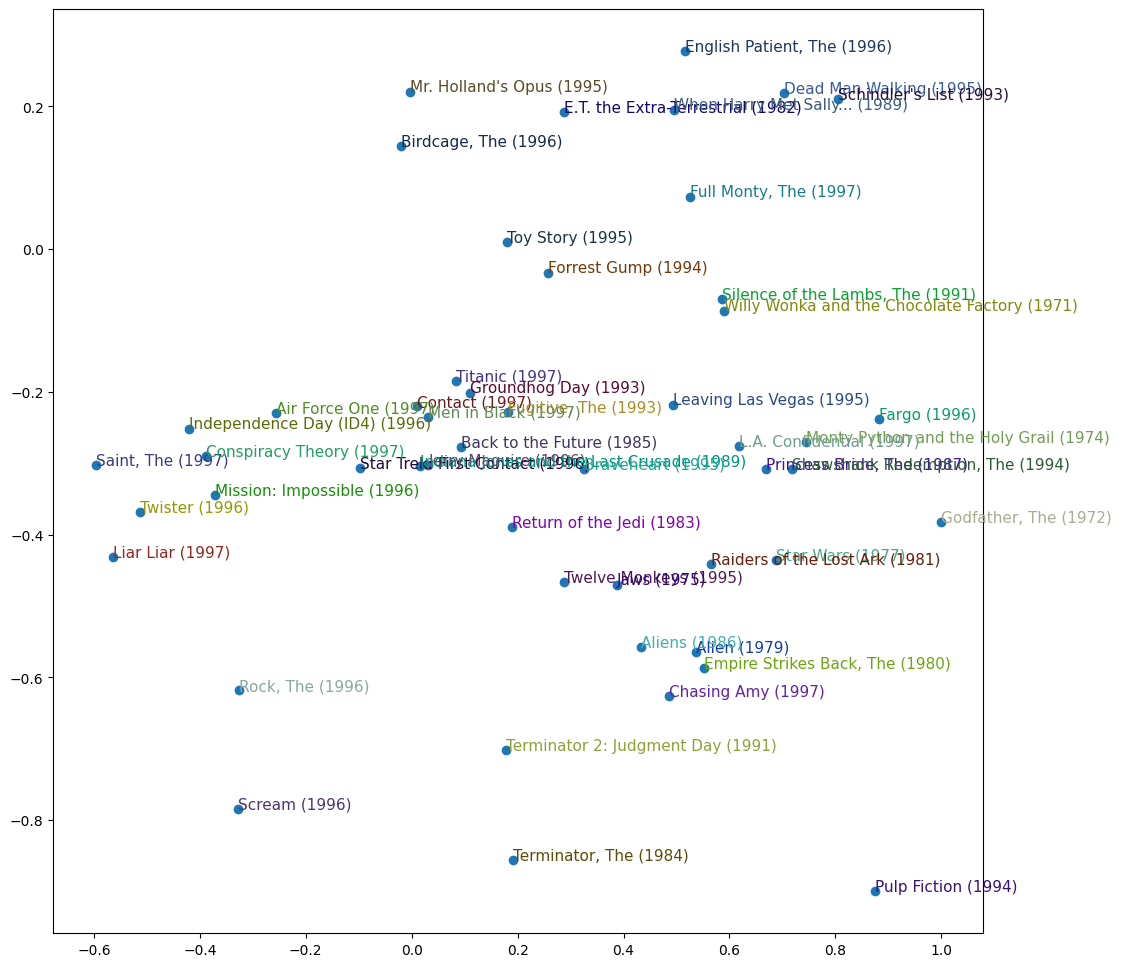

In [ ]:
# movies based on two strongest principal component analysis (underlying directions in a matrix)

g = ratings.groupby('title')['rating'].count()
top_movies = g.sort_values(ascending=False).index.values[:1000]
top_idxs = tensor([learn.dls.classes['title'].o2i[m] for m in top_movies])
movie_w = learn.model.movie_factors[top_idxs].cpu().detach()
movie_pca = movie_w.pca(3)
fac0,fac1,fac2 = movie_pca.t()
idxs = list(range(50))
X = fac0[idxs]
Y = fac2[idxs]
plt.figure(figsize=(12,12))
plt.scatter(X, Y)
for i, x, y in zip(top_movies[idxs], X, Y):
    plt.text(x,y,i, color=np.random.rand(3)*0.7, fontsize=11)
plt.show()

In [ ]:
# using  collab filtering model with the same struncutre and training it using the fastai function collab learner
# couldbe skipped all of the previous stufff, it's just what's inside of this one

learn = collab_learner(dls, n_factors=50, y_range=(0, 5.5))

In [ ]:
learn.fit_one_cycle(5, 5e-3, wd=0.1)

epoch,train_loss,valid_loss,time
0,0.941115,0.957840,00:07
1,0.836133,0.873571,00:08
2,0.710926,0.832362,00:07
3,0.590745,0.819206,00:07
4,0.467776,0.819885,00:07


In [ ]:
learn.model

EmbeddingDotBias(
  (u_weight): Embedding(944, 50)
  (i_weight): Embedding(1665, 50)
  (u_bias): Embedding(944, 1)
  (i_bias): Embedding(1665, 1)
)

In [ ]:
# use that to replicate previous analyses

movie_bias = learn.model.i_bias.weight.squeeze()
idxs = movie_bias.argsort(descending=True)[:5]
[dls.classes['title'][i] for i in idxs]

['Total Eclipse (1995)',
 'Show, The (1995)',
 'Aliens (1986)',
 'Suture (1993)',
 'Mary Reilly (1996)']

In [ ]:
# looking at distance between coordinates 
# the distance between movie embedding vectors defines simialirty

movie_factors = learn.model.i_weight.weight
idx = dls.classes['title'].o2i['Silence of the Lambs, The (1991)']
distances = nn.CosineSimilarity(dim=1)(movie_factors, movie_factors[idx][None])
idx = distances.argsort(descending=True)[1]
dls.classes['title'][idx]

# drop dead fred

'Drop Dead Fred (1991)'

- bootstrapping problem: what do you recommend to new users?
- use tabular model based on user meta data 
- using questions to help interpret those results
- be aware of overly enthusiastic users, anime dudes with heavy bias
- feedback loops to prevent this

In [ ]:
# turn stuff into deeep learning model
# take results of embedding lookup and concatenate together

embs = get_emb_sz(dls)
embs

[(944, 74), (1665, 102)]

In [ ]:
class CollabNN(Module):
    def __init__(self, user_sz, item_sz, y_range=(0,5.5), n_act=100):
        self.user_factors = Embedding(*user_sz)
        self.item_factors = Embedding(*item_sz)
        self.layers = nn.Sequential(
            nn.Linear(user_sz[1]+item_sz[1], n_act),
            nn.ReLU(),
            nn.Linear(n_act, 1))
        self.y_range = y_range
        
    def forward(self, x):
        embs = self.user_factors(x[:,0]),self.item_factors(x[:,1])
        x = self.layers(torch.cat(embs, dim=1))
        return sigmoid_range(x, *self.y_range)

In [ ]:
# use that to create a model
# creates embedding layers using embs sizes

model = CollabNN(*embs)

In [ ]:
learn = Learner(dls, model, loss_func=MSELossFlat())
learn.fit_one_cycle(5, 5e-3, wd=0.01)

epoch,train_loss,valid_loss,time
0,0.944738,0.950076,00:10
1,0.915485,0.902034,00:10
2,0.851923,0.883990,00:10
3,0.816610,0.875533,00:09
4,0.766835,0.879596,00:11


In [ ]:
# if you pass use_nn=True in your call to collab_learner (including calling get_emb_sz for you), and it lets you easily create more layers
# two hidden layers 100 and 50

learn = collab_learner(dls, use_nn=True, y_range=(0, 5.5), layers=[100,50])
learn.fit_one_cycle(5, 5e-3, wd=0.1)

epoch,train_loss,valid_loss,time
0,1.015211,1.005399,00:12
1,0.880994,0.930209,00:15
2,0.887551,0.899196,00:14
3,0.824220,0.872969,00:13
4,0.798360,0.870505,00:12


`learn.model` is an object of type `EmbeddingNN`. Let's take a look at fastai's code for this class:

In [ ]:
# inherits from tabular model, gets functions from it
# innit calls same models passing n_... and stuff and passes along whatever arguments are received

@delegates(TabularModel)
class EmbeddingNN(TabularModel):
    def __init__(self, emb_szs, layers, **kwargs):
        super().__init__(emb_szs, layers=layers, n_cont=0, out_sz=1, **kwargs)

- embeddingNN has worse results than the previous dot product stuff??
- let's us incorporate other user, movie, etc. info that might be relevant to recommendation

# Theoretical Part

1. What problem does collaborative filtering solve?

Collaborative Filtering is used for recommendatino systems (like content or items) based on preferences of users. It makes recommendations and predictions according to the behavior of user groups.

2. How does it solve it?

It does so by analyzing the collective wisdom of user groups as well as analyzing the past data of user preferences and identifies patterns and similarities. These are used in combination with preferences of similar users, to make recommendations and predictions for users. 

3. What is a dot product? Calculate a dot product manually using pure Python with lists.

Dot products are the result of mulitplying two vectors and summing their result. It forms the basis of matrix multiplication and is an important part of machine learning.

Example code will be in the section after this.

4. What does pandas.DataFrame.merge do?

This is a function that combines multiple dataframes bassed on a column or index. The type of join can be specified, like in SQL. It allows for the combination of datasets from different sources or tables into one dataframe for better analysis and data manipulation.

5. What does argsort do in PyTorch?

This function can be used to obtain a new tensor that contains the indices of the original tensor but sorted. It can be used for ranking or sorting tasks.

6. What is the "bootstrapping problem" in collaborative filtering?

The bootstrapping problem refers to the challenge of providing recommendations to new users due to missing information and preferences. This can be solved or avoided by recommending generally popular content or asking a few questions prior to making recommendations for basic assessments.

7. What is the use of bias in a dot product model?

Bias are added constants used in a dot product because it adds increased adjustability. This improves the model by allowing it to make more accurate recommendations based on user data.




In [ ]:
# 3: basic dot example
vector1 = [6, 0, 6]
vector2 = [7, 9, 4]

dot_result = sum(x * y for x, y in zip(vector1, vector2))

dot_result
# result = 66

66